# Purpose:
- Calculate clusterig index across learning
- First, from the test sessions, for all 7 angles
- Then, from the training sessions
- Also look at the change bewteen neighboring sessions using matched cells

In [1]:
import numpy as np
import pandas as pd
import xarray as xr
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
import utils.matched_roi as mr
import utils.merged_df_annotation as mda
import utils.population_activity as pa
import utils.clustering_index as ci
from scipy.spatial.distance import pdist, squareform, cdist
from scipy import stats
from importlib import reload

base_dir = Path(r'E:\TPM\JK\h5')
behavior_dir = Path(r'E:\TPM\JK\SoloData')
results_dir = base_dir / 'results'
load_dir = results_dir / 'pop_responses' / 'touch_before_answer'

expert_mice_df = pd.read_csv(base_dir / 'expert_mice.csv', index_col=0)
use_mice_df = expert_mice_df.loc[expert_mice_df['depth_matched'].astype(bool) & 
                                 ~expert_mice_df['processing_error'].astype(bool) &
                                 ((expert_mice_df.session_type == 'training') |
                                  (expert_mice_df.session_type.str.contains('test')))]
use_volume_df = use_mice_df.query('plane in [1, 5]')
use_volume_df.loc[:, 'volume'] = use_volume_df['plane'].apply(lambda x: 1 if x==1 else 2)
training_volume_df = use_volume_df.query('session_type == "training"')
remove_ind = training_volume_df.query('mouse==27 and session=="15"')
training_volume_df = training_volume_df.drop(remove_ind.index)
remove_ind = training_volume_df.query('mouse==36 and session=="9"')
training_volume_df = training_volume_df.drop(remove_ind.index)

mice = [25,27,30,36,39,52]
test_sessions = [[4,19], [3,8], [3,21], [1,17], [1,23], [3,21]]
naive_sessions = [10, 4, 11, 6, 6, 11]



c:\Users\shires\Anaconda3\envs\suite2p\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


# Calculating clustering index
- 1/k * (sum)(from i=0 to k) ( (between-group distance) - (within-group distance) / (between-group distance) + (within-group distance) )

In [6]:
mouse = 25
volume = 1
top_plane = 1 if volume==1 else 5
# sessions = np.array([int(s) for s in use_mice_df.query('mouse==@mouse and plane==@top_plane').session.values])
# si = 0
# session = sessions[si]
session = 4

touch_window='before_answer'
spk_norm='std'
varexp_threshold=0.05
post_touch_frames=1

per_touch_response_xr_fit, per_touch_response_df, per_touch_response_xr = \
    pa.get_touch_response_xr_varexp_threshold(base_dir, mouse, top_plane, session,
                                              touch_window=touch_window,
                                              spk_norm=spk_norm,
                                              varexp_threshold=varexp_threshold,
                                              post_touch_frames=post_touch_frames)


In [25]:
dim_nums = np.arange(3,17,2)
angles = per_touch_response_df.pole_angle.unique()
pca = PCA()
pca.fit(per_touch_response_xr_fit)
dim_num = 3



Text(0.5, 0, 'PC3')

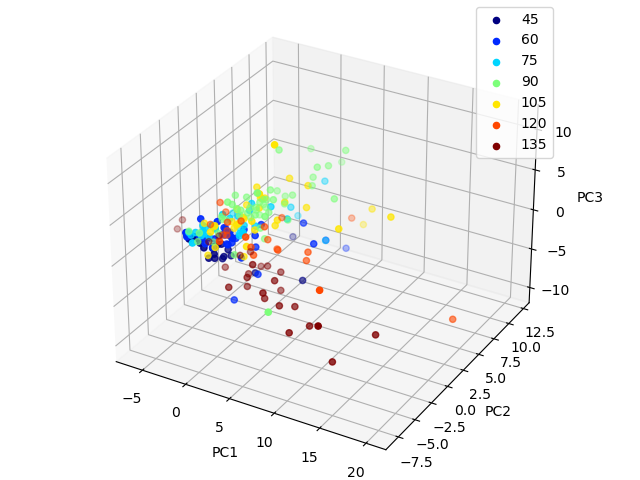

In [24]:
%matplotlib widget
fig = plt.figure()
ax = Axes3D(fig, auto_add_to_figure=False)
fig.add_axes(ax)

angles = np.unique(per_touch_response_df.pole_angle)
colors = plt.cm.jet(np.linspace(0,1,len(angles)))
for ai, angle in enumerate(angles):
    angle_tns = per_touch_response_df[per_touch_response_df.pole_angle==angle].trialNum.values
    responses_angle = per_touch_response_xr_fit.sel(trialNum=angle_tns)
    pc = pca.transform(responses_angle)
    ax.scatter(pc[:,0], pc[:,1], pc[:,2], color=colors[ai], label=angle)
ax.legend()
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')

In [26]:
angles = np.unique(per_touch_response_df.pole_angle)
pc_all_angles = []
for ai, angle in enumerate(angles):
    angle_tns = per_touch_response_df[per_touch_response_df.pole_angle==angle].trialNum.values
    responses_angle = per_touch_response_xr_fit.sel(trialNum=angle_tns)
    pc = pca.transform(responses_angle)
    pc_all_angles.append(pc)


In [54]:
num_dim = 3
num_groups = len(angles)
clustering_index_trial = []
for gi in range(num_groups):
    this_group = pc_all_angles[gi]
    other_group = np.concatenate([pc_all_angles[i] for i in range(num_groups) if i!=gi])
    within_group_dist = squareform(pdist(this_group[:, :num_dim], 'euclidean'))
    between_group_dist = cdist(this_group[:, :num_dim], other_group[:, :num_dim], 'euclidean')
    num_trials = this_group.shape[0]
    for ti in range(num_trials):
        within_group_mean = within_group_dist[ti,:].sum() / (num_trials-1)
        between_group_mean = between_group_dist[ti,:].mean()
        clustering_index_trial.append((between_group_mean - within_group_mean) / (between_group_mean + within_group_mean))
clustering_index = np.mean(clustering_index_trial)


0.17208546910499262


# Population responses
- it takes up the most time. (~15 seconds per volume)
- Save them first.
- In 'pop_responses' folder under results_dir
    - It should have 6 folders - before_pole, before_answer, after_answer, after_pole, touch_before_answer, touch_after_answer.
    - Normalization within angle fixed to std for now
    - varexp_threshold fixed to 0.05 (for now)
        - Can always get others from unfit xarray
        - Indicate this value in the file name (ve)
    - For touch responses, post touch_frame can be 0, 1, and 2
        - Indicate them in the file name (ptf)
- Using a script
    - 'touch_before_answer' for now. I had problems with 'touch_after_answer', and haven't solved it yet.
    - scripts.save_touch_responses.py

# Calculate clustering index across learning
- Test sessions
- Test sessions with 45 and 135 degrees only (PCA using all the angles)
- Across training sessions

In [63]:
results_dir = base_dir / 'results'
load_dir = results_dir / 'pop_responses' / 'touch_before_answer'


In [70]:
reload(ci)
mouse = 25
volume = 1
session = 1
touch_response_fn = f'JK{mouse:03}_volume{volume}_S{session:02}_ve_{varexp_threshold}_ptf_{post_touch_frames}.npy'
touch_response_results = np.load(load_dir / touch_response_fn, allow_pickle=True).item()
response_xr = touch_response_results['per_touch_response_xr_fit']
response_df = touch_response_results['per_touch_response_df']
ci.calculate_clustering_index(response_xr, response_df, num_dims=3)

[0.45682287030144597]

## Between test sessions

In [78]:
use_volume_df.columns

Index(['Unnamed: 0.1', 'mouse', 'plane', 'session', 'session_type',
       'depth_matched', 'processing_error', 'remove_frame_ind', 'volume'],
      dtype='object')

In [81]:
use_volume_df.session_type.unique()

array(['training', 'test_naive', 'test_expert'], dtype=object)

### All angles

In [139]:
ci_upper_naive = []
ci_upper_expert = []
ci_lower_naive = []
ci_lower_expert = []
num_dims = np.arange(3,16,2)
for mi, mouse in enumerate(mice):    
    for volume in [1,2]:
        if mouse == 27 and volume == 1:
            continue
        for ti, session in enumerate(test_sessions[mi]):
            touch_response_fn = f'JK{mouse:03}_volume{volume}_S{session:02}_ve_{varexp_threshold}_ptf_{post_touch_frames}.npy'
            touch_response_results = np.load(load_dir / touch_response_fn, allow_pickle=True).item()
            response_xr = touch_response_results['per_touch_response_xr_fit']
            response_df = touch_response_results['per_touch_response_df']
            clustering_index = ci.calculate_clustering_index(response_xr, response_df, num_dims=num_dims)
            if volume == 1:
                if ti == 0:
                    ci_upper_naive.append(clustering_index)
                else:
                    ci_upper_expert.append(clustering_index)
            else:
                if ti == 0:
                    ci_lower_naive.append(clustering_index)
                else:
                    ci_lower_expert.append(clustering_index)
ci_upper_naive = np.array(ci_upper_naive)
ci_upper_expert = np.array(ci_upper_expert)
ci_lower_naive = np.array(ci_lower_naive)
ci_lower_expert = np.array(ci_lower_expert)
ci_naive = np.concatenate([ci_upper_naive, ci_lower_naive])
ci_expert = np.concatenate([ci_upper_expert, ci_lower_expert])

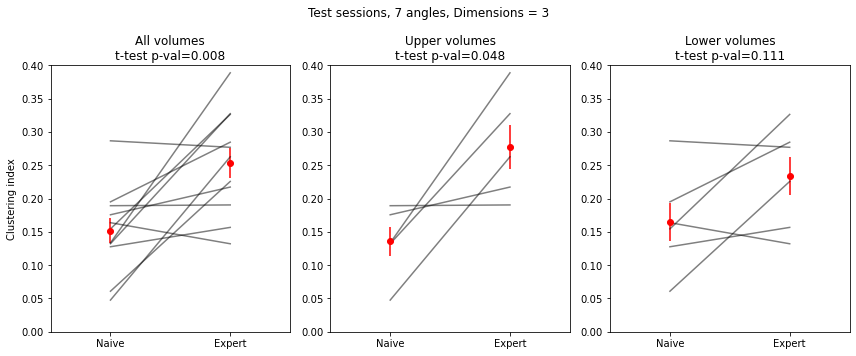

In [142]:
num_dim = 3
dim_ind = np.where(num_dims==num_dim)[0][0]

ylims = [0, 0.4]
fig, ax = plt.subplots(1,3, figsize=(12,5))

ax[0].errorbar([0, 1], [np.mean(ci_naive[:,dim_ind]), np.mean(ci_expert[:,dim_ind])], 
               [np.std(ci_naive[:,dim_ind])/np.sqrt(ci_naive.shape[0]),
                np.std(ci_expert[:,dim_ind])/np.sqrt(ci_expert.shape[0])],
                color='r', fmt='o')
for i in range(ci_naive.shape[0]):
    ax[0].plot([0,1], [ci_naive[i,dim_ind], ci_expert[i,dim_ind]], 'k-', alpha=0.5)
ax[0].set_ylabel('Clustering index')
t, p = stats.ttest_rel(ci_naive[:,dim_ind], ci_expert[:,dim_ind])
ax[0].set_title(f'All volumes\nt-test p-val={p:.3f}')

ax[1].errorbar([0, 1], [np.mean(ci_upper_naive[:,dim_ind]), np.mean(ci_upper_expert[:,dim_ind])],
                [np.std(ci_upper_naive[:,dim_ind])/np.sqrt(ci_upper_naive.shape[0]),
                 np.std(ci_upper_expert[:,dim_ind])/np.sqrt(ci_upper_expert.shape[0])],
                 color='r', fmt='o')
for i in range(ci_upper_naive.shape[0]):
    ax[1].plot([0,1], [ci_upper_naive[i,dim_ind], ci_upper_expert[i,dim_ind]], 'k-', alpha=0.5)
t, p = stats.ttest_rel(ci_upper_naive[:,dim_ind], ci_upper_expert[:,dim_ind])
ax[1].set_title(f'Upper volumes\nt-test p-val={p:.3f}')

ax[2].errorbar([0, 1], [np.mean(ci_lower_naive[:,dim_ind]), np.mean(ci_lower_expert[:,dim_ind])],
                [np.std(ci_lower_naive[:,dim_ind])/np.sqrt(ci_lower_naive.shape[0]),
                 np.std(ci_lower_expert[:,dim_ind])/np.sqrt(ci_lower_expert.shape[0])],
                 color='r', fmt='o')
for i in range(ci_lower_naive.shape[0]):
    ax[2].plot([0,1], [ci_lower_naive[i,dim_ind], ci_lower_expert[i,dim_ind]], 'k-', alpha=0.5)
t, p = stats.ttest_rel(ci_lower_naive[:,dim_ind], ci_lower_expert[:,dim_ind])
ax[2].set_title(f'Lower volumes\nt-test p-val={p:.3f}')

for axx in ax:
    axx.set_ylim(ylims)
    axx.set_xticks([0,1])
    axx.set_xticklabels(['Naive', 'Expert'])
    axx.set_xlim([-0.5, 1.5])

fig.suptitle(f'Test sessions, 7 angles, Dimensions = {num_dim}')
fig.tight_layout()

### Between 2 angles, after PCA from all trials

In [129]:
ci_upper_naive = []
ci_upper_expert = []
ci_lower_naive = []
ci_lower_expert = []
num_dims = np.arange(3,16,2)
angles = np.array([45,135])
for mi, mouse in enumerate(mice):    
    for volume in [1,2]:
        if mouse == 27 and volume == 1:
            continue
        for ti, session in enumerate(test_sessions[mi]):
            touch_response_fn = f'JK{mouse:03}_volume{volume}_S{session:02}_ve_{varexp_threshold}_ptf_{post_touch_frames}.npy'
            touch_response_results = np.load(load_dir / touch_response_fn, allow_pickle=True).item()
            response_xr = touch_response_results['per_touch_response_xr_fit']
            response_df = touch_response_results['per_touch_response_df']
            clustering_index = ci.calculate_clustering_index(response_xr, response_df,
                                                             num_dims=num_dims,
                                                             angles=angles)
            if volume == 1:
                if ti == 0:
                    ci_upper_naive.append(clustering_index)
                else:
                    ci_upper_expert.append(clustering_index)
            else:
                if ti == 0:
                    ci_lower_naive.append(clustering_index)
                else:
                    ci_lower_expert.append(clustering_index)
ci_upper_naive = np.array(ci_upper_naive)
ci_upper_expert = np.array(ci_upper_expert)
ci_lower_naive = np.array(ci_lower_naive)
ci_lower_expert = np.array(ci_lower_expert)
ci_naive = np.concatenate([ci_upper_naive, ci_lower_naive])
ci_expert = np.concatenate([ci_upper_expert, ci_lower_expert])

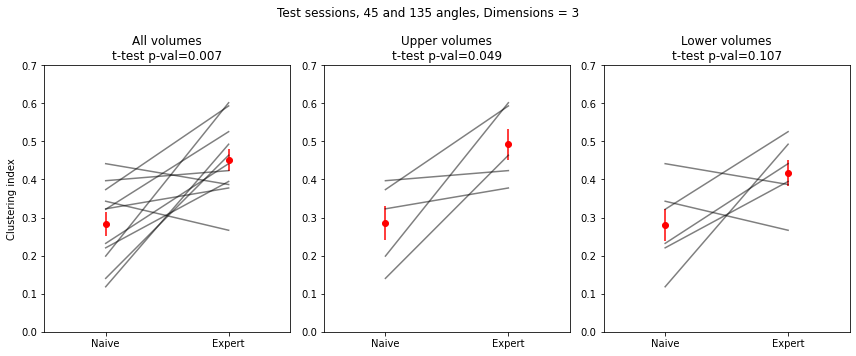

In [138]:
num_dim = 3
dim_ind = np.where(num_dims==num_dim)[0][0]

ylims = [0, 0.7]
fig, ax = plt.subplots(1,3, figsize=(12,5))

ax[0].errorbar([0, 1], [np.mean(ci_naive[:,dim_ind]), np.mean(ci_expert[:,dim_ind])], 
               [np.std(ci_naive[:,dim_ind])/np.sqrt(ci_naive.shape[0]),
                np.std(ci_expert[:,dim_ind])/np.sqrt(ci_expert.shape[0])],
                color='r', fmt='o')
for i in range(ci_naive.shape[0]):
    ax[0].plot([0,1], [ci_naive[i,dim_ind], ci_expert[i,dim_ind]], 'k-', alpha=0.5)
ax[0].set_ylabel('Clustering index')
t, p = stats.ttest_rel(ci_naive[:,dim_ind], ci_expert[:,dim_ind])
ax[0].set_title(f'All volumes\nt-test p-val={p:.3f}')

ax[1].errorbar([0, 1], [np.mean(ci_upper_naive[:,dim_ind]), np.mean(ci_upper_expert[:,dim_ind])],
                [np.std(ci_upper_naive[:,dim_ind])/np.sqrt(ci_upper_naive.shape[0]),
                 np.std(ci_upper_expert[:,dim_ind])/np.sqrt(ci_upper_expert.shape[0])],
                 color='r', fmt='o')
for i in range(ci_upper_naive.shape[0]):
    ax[1].plot([0,1], [ci_upper_naive[i,dim_ind], ci_upper_expert[i,dim_ind]], 'k-', alpha=0.5)
t, p = stats.ttest_rel(ci_upper_naive[:,dim_ind], ci_upper_expert[:,dim_ind])
ax[1].set_title(f'Upper volumes\nt-test p-val={p:.3f}')

ax[2].errorbar([0, 1], [np.mean(ci_lower_naive[:,dim_ind]), np.mean(ci_lower_expert[:,dim_ind])],
                [np.std(ci_lower_naive[:,dim_ind])/np.sqrt(ci_lower_naive.shape[0]),
                 np.std(ci_lower_expert[:,dim_ind])/np.sqrt(ci_lower_expert.shape[0])],
                 color='r', fmt='o')
for i in range(ci_lower_naive.shape[0]):
    ax[2].plot([0,1], [ci_lower_naive[i,dim_ind], ci_lower_expert[i,dim_ind]], 'k-', alpha=0.5)
t, p = stats.ttest_rel(ci_lower_naive[:,dim_ind], ci_lower_expert[:,dim_ind])
ax[2].set_title(f'Lower volumes\nt-test p-val={p:.3f}')

for axx in ax:
    axx.set_ylim(ylims)
    axx.set_xticks([0,1])
    axx.set_xticklabels(['Naive', 'Expert'])
    axx.set_xlim([-0.5, 1.5])

fig.suptitle(f'Test sessions, 45 and 135 angles, Dimensions = {num_dim}')
fig.tight_layout()

### Between 2 angles, after PCA from 45 and 135 trials

In [144]:
reload(ci)
ci_upper_naive = []
ci_upper_expert = []
ci_lower_naive = []
ci_lower_expert = []
num_dims = np.arange(3,16,2)
angles = np.array([45,135])
for mi, mouse in enumerate(mice):    
    for volume in [1,2]:
        if mouse == 27 and volume == 1:
            continue
        for ti, session in enumerate(test_sessions[mi]):
            touch_response_fn = f'JK{mouse:03}_volume{volume}_S{session:02}_ve_{varexp_threshold}_ptf_{post_touch_frames}.npy'
            touch_response_results = np.load(load_dir / touch_response_fn, allow_pickle=True).item()
            response_xr = touch_response_results['per_touch_response_xr_fit']
            response_df = touch_response_results['per_touch_response_df']
            clustering_index = ci.calculate_clustering_index(response_xr, response_df,
                                                             num_dims=num_dims,
                                                             angles=angles,
                                                             pca_specific=True)
            if volume == 1:
                if ti == 0:
                    ci_upper_naive.append(clustering_index)
                else:
                    ci_upper_expert.append(clustering_index)
            else:
                if ti == 0:
                    ci_lower_naive.append(clustering_index)
                else:
                    ci_lower_expert.append(clustering_index)
ci_upper_naive = np.array(ci_upper_naive)
ci_upper_expert = np.array(ci_upper_expert)
ci_lower_naive = np.array(ci_lower_naive)
ci_lower_expert = np.array(ci_lower_expert)
ci_naive = np.concatenate([ci_upper_naive, ci_lower_naive])
ci_expert = np.concatenate([ci_upper_expert, ci_lower_expert])

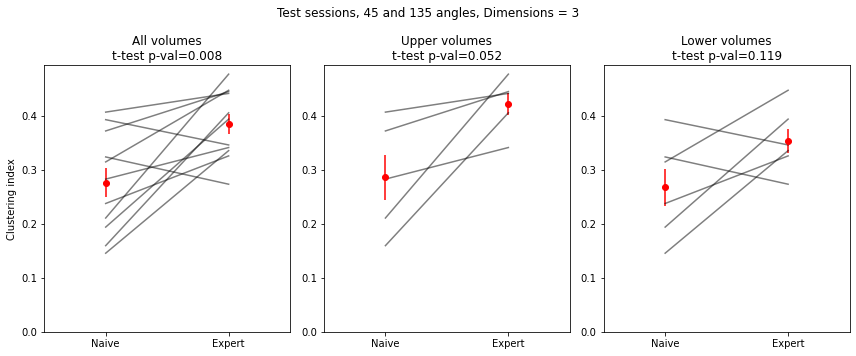

In [149]:
num_dim = 3
dim_ind = np.where(num_dims==num_dim)[0][0]
fig, ax = plt.subplots(1,3, figsize=(12,5))

ax[0].errorbar([0, 1], [np.mean(ci_naive[:,dim_ind]), np.mean(ci_expert[:,dim_ind])], 
               [np.std(ci_naive[:,dim_ind])/np.sqrt(ci_naive.shape[0]),
                np.std(ci_expert[:,dim_ind])/np.sqrt(ci_expert.shape[0])],
                color='r', fmt='o')
for i in range(ci_naive.shape[0]):
    ax[0].plot([0,1], [ci_naive[i,dim_ind], ci_expert[i,dim_ind]], 'k-', alpha=0.5)
ax[0].set_ylabel('Clustering index')
t, p = stats.ttest_rel(ci_naive[:,dim_ind], ci_expert[:,dim_ind])
ax[0].set_title(f'All volumes\nt-test p-val={p:.3f}')

ax[1].errorbar([0, 1], [np.mean(ci_upper_naive[:,dim_ind]), np.mean(ci_upper_expert[:,dim_ind])],
                [np.std(ci_upper_naive[:,dim_ind])/np.sqrt(ci_upper_naive.shape[0]),
                 np.std(ci_upper_expert[:,dim_ind])/np.sqrt(ci_upper_expert.shape[0])],
                 color='r', fmt='o')
for i in range(ci_upper_naive.shape[0]):
    ax[1].plot([0,1], [ci_upper_naive[i,dim_ind], ci_upper_expert[i,dim_ind]], 'k-', alpha=0.5)
t, p = stats.ttest_rel(ci_upper_naive[:,dim_ind], ci_upper_expert[:,dim_ind])
ax[1].set_title(f'Upper volumes\nt-test p-val={p:.3f}')

ax[2].errorbar([0, 1], [np.mean(ci_lower_naive[:,dim_ind]), np.mean(ci_lower_expert[:,dim_ind])],
                [np.std(ci_lower_naive[:,dim_ind])/np.sqrt(ci_lower_naive.shape[0]),
                 np.std(ci_lower_expert[:,dim_ind])/np.sqrt(ci_lower_expert.shape[0])],
                 color='r', fmt='o')
for i in range(ci_lower_naive.shape[0]):
    ax[2].plot([0,1], [ci_lower_naive[i,dim_ind], ci_lower_expert[i,dim_ind]], 'k-', alpha=0.5)
t, p = stats.ttest_rel(ci_lower_naive[:,dim_ind], ci_lower_expert[:,dim_ind])
ax[2].set_title(f'Lower volumes\nt-test p-val={p:.3f}')

ylim_max = 0
for axx in ax:
    ylim_max = max(ylim_max, axx.get_ylim()[1])
ylims = [0, ylim_max]
for axx in ax:
    axx.set_ylim(ylims)
    axx.set_xticks([0,1])
    axx.set_xticklabels(['Naive', 'Expert'])
    axx.set_xlim([-0.5, 1.5])

fig.suptitle(f'Test sessions, 45 and 135 angles, Dimensions = {num_dim}')
fig.tight_layout()

## Across training sessions

In [194]:
training_volume_df = use_volume_df.query('session_type == "training"')
remove_ind = training_volume_df.query('mouse==27 and session=="15"')
training_volume_df = training_volume_df.drop(remove_ind.index)
training_volume_df.query('mouse==27 and volume==2')

,Unnamed: 0.1,mouse,plane,session,session_type,depth_matched,processing_error,remove_frame_ind,volume
324,324,27,5,1,training,True,False,0,2
325,325,27,5,2,training,True,False,0,2
327,327,27,5,4,training,True,False,[5102 7316],2
328,328,27,5,5,training,True,False,0,2
329,329,27,5,6,training,True,False,0,2


In [170]:
mouse = 36
volume = 2
temp_df = training_volume_df.query('mouse==@mouse and volume==@volume')
sessions = [int(s) for s in temp_df.session.values]
for session in sessions:
    touch_response_fn = f'JK{mouse:03}_volume{volume}_S{session:02}_ve_{varexp_threshold}_ptf_{post_touch_frames}.npy'
    touch_response_results = np.load(load_dir / touch_response_fn, allow_pickle=True).item()
    response_xr = touch_response_results['per_touch_response_xr_fit']
    response_df = touch_response_results['per_touch_response_df']
    clustering_index = ci.calculate_clustering_index(response_xr, response_df, num_dims=num_dims)
    print(f'Session {session}, Clustering index = {clustering_index}')


Session 2, Clustering index = [0.32946375198277994, 0.2805068191234096, 0.24505611860388404, 0.2220838368780131, 0.20291385525860786, 0.1883897694187779, 0.17900255302373208]
Session 3, Clustering index = [0.2750608111647165, 0.22076777415398138, 0.18869114649719568, 0.16921666539158522, 0.152121597077814, 0.13973129313434443, 0.12943045038565013]
Session 4, Clustering index = [0.3358931910942879, 0.2772767922703515, 0.24475210387805854, 0.21613145857211494, 0.19359217388070069, 0.1852938446005461, 0.17619524108105228]
Session 5, Clustering index = [0.35551542015816245, 0.2780560121872827, 0.24686641781417046, 0.2254394544336898, 0.20926898929852247, 0.19770785035552127, 0.18909485904809367]
Session 6, Clustering index = [0.34512983362232075, 0.30980700958743085, 0.28484177267416116, 0.2745144988574924, 0.26886326176616776, 0.2639305544832446, 0.25386469924034194]
Session 7, Clustering index = [0.36789586041755584, 0.30239791917357906, 0.2567580102913527, 0.2400739573817646, 0.22685799

In [171]:
mouse = 36
volume = 1
temp_df = training_volume_df.query('mouse==@mouse and volume==@volume')
sessions = [int(s) for s in temp_df.session.values]
for session in sessions:
    touch_response_fn = f'JK{mouse:03}_volume{volume}_S{session:02}_ve_{varexp_threshold}_ptf_{post_touch_frames}.npy'
    touch_response_results = np.load(load_dir / touch_response_fn, allow_pickle=True).item()
    response_xr = touch_response_results['per_touch_response_xr_fit']
    response_df = touch_response_results['per_touch_response_df']
    clustering_index = ci.calculate_clustering_index(response_xr, response_df, num_dims=num_dims)
    print(f'Session {session}, Clustering index = {clustering_index}')


Session 2, Clustering index = [0.30502587608380394, 0.27808221989128606, 0.228198905869384, 0.20096664980470252, 0.18353486222928736, 0.16838319071038255, 0.1569973165700444]
Session 3, Clustering index = [0.2813009699539014, 0.23445153318471576, 0.19981540238709003, 0.18138179330467566, 0.16704742924648933, 0.1559272764505306, 0.14456035631329905]
Session 4, Clustering index = [0.40578353980385296, 0.29203734877739046, 0.2448094197004585, 0.2244872862915854, 0.21165913371683753, 0.19736458967399806, 0.18668614063770303]
Session 5, Clustering index = [0.40014826817888727, 0.31982293381442434, 0.27709251112372146, 0.25578655339354067, 0.23780093700815055, 0.22531703937442354, 0.21607662271694403]
Session 6, Clustering index = [0.4224968180033513, 0.3923667626062925, 0.37194868810109555, 0.3436376153420359, 0.3309913505187162, 0.3213378944048915, 0.3113814807246208]
Session 7, Clustering index = [0.3940366840001532, 0.3305894823525022, 0.2847467216791813, 0.2647225893214852, 0.2488516699

ValueError: need at least one array to concatenate

### (for later) JK036 volume 1 session 9 errors
- All 100 trials are only from 135 degrees
- Corresponding session from volume 2 shows very high clustering index

### First, check the variability across dimensions

Text(0.5, 1.0, 'JK027 volume 2')

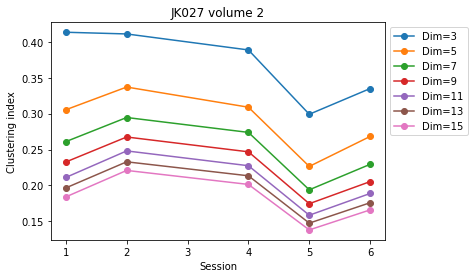

In [195]:
mouse = 27
volume = 2
num_dims = np.arange(3,16,2)
temp_df = training_volume_df.query('mouse==@mouse and volume==@volume')
sessions = [int(s) for s in temp_df.session.values]
ci_sessions = []
ci_session_nums = []
for session in sessions:
    touch_response_fn = f'JK{mouse:03}_volume{volume}_S{session:02}_ve_{varexp_threshold}_ptf_{post_touch_frames}.npy'
    touch_response_results = np.load(load_dir / touch_response_fn, allow_pickle=True).item()
    response_xr = touch_response_results['per_touch_response_xr_fit']
    response_df = touch_response_results['per_touch_response_df']
    try:
        clustering_index = ci.calculate_clustering_index(response_xr, response_df, num_dims=num_dims,
                                                         balance_trials=False)
        ci_session_nums.append(session)
        ci_sessions.append(clustering_index)
    except:
        pass
ci_sessions = np.array(ci_sessions)
fig, ax = plt.subplots()
for i in range(ci_sessions.shape[1]):
    ax.plot(ci_session_nums, ci_sessions[:,i], 'o-', label=f'Dim={num_dims[i]}')
ax.legend(loc='upper left', bbox_to_anchor=(1,1))
ax.set_xlabel('Session')
ax.set_ylabel('Clustering index')
ax.set_title(f'JK{mouse:03} volume {volume}')

## Clustering index variation
- Change pattern is similar across dimensions
    - Look at dim=7 from now on (explaining ~50% of variance)
- Huge variation across sessions
    - What is the cause?
        - Imbalance in # of touch trials?
        - Imbalance in touch quality?
    - Investigate on "naive" sessions
        - Define it based on d' and d'max(60)

In [196]:
behavior_dir = Path(r'E:\TPM\JK\SoloData')

In [232]:
def get_correct_rate(behavior_dir, mouse, session, rolling_window=None):
    behavior_fn = behavior_dir / f'JK{mouse:03}' / f'JK{mouse:03}S{session:02}_behavior.pkl'
    behavior_data = pd.read_pickle(behavior_fn)
    temp = behavior_data.query('choice != "m"')[['choice', 'trialType']]
    correct_df = temp.apply(lambda x: x.choice == x.trialType[0], axis=1)
    if rolling_window is None:
        session_correct_rate = correct_df.sum() / correct_df.shape[0]
    else:
        session_correct_rate = correct_df.rolling(rolling_window).apply(lambda x: x.sum() / x.shape[0]).max()
    return session_correct_rate

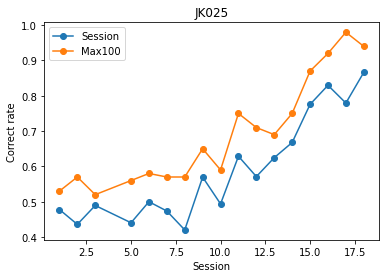

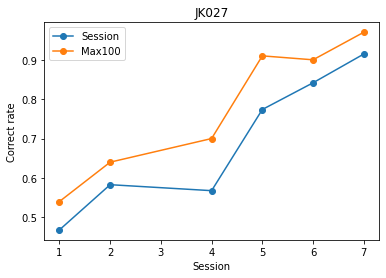

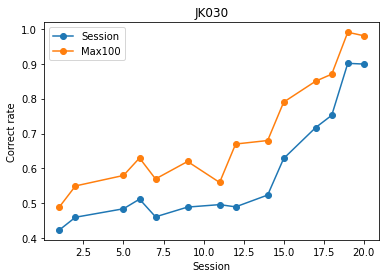

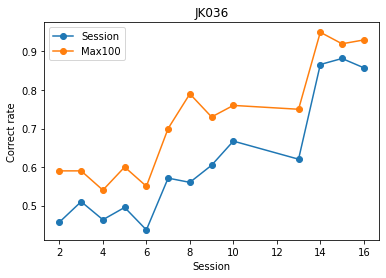

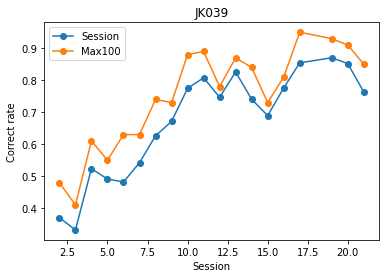

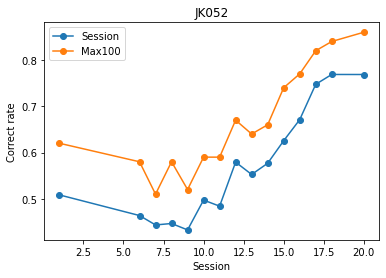

In [245]:
rolling_window = 100
for mouse in mice:
    sessions = np.sort([int(s) for s in training_volume_df.query('mouse==@mouse').session.unique()])
    cr = []
    cr_max_rolling = []
    for session in sessions:
        cr.append(get_correct_rate(behavior_dir, mouse, session))
        cr_max_rolling.append(get_correct_rate(behavior_dir, mouse, session,
                                         rolling_window=rolling_window))
    fig, ax = plt.subplots()
    ax.plot(sessions, cr, 'o-', label='Session')
    ax.plot(sessions, cr_max_rolling, 'o-', label=f'Max{rolling_window}')
    ax.legend()
    ax.set_xlabel('Session')
    ax.set_ylabel('Correct rate')
    ax.set_title(f'JK{mouse:03}')

## Rough naive sessions
- [10, 4, 11, 6, 6, 11]
- Inclusive

In [ ]:
naive_sessions = [10, 4, 11, 6, 6, 11]

# Balancing the number of touch trials

In [4]:
num_trials_all = []
for mouse in mice:
    for volume in [1,2]:
        num_trials = []
        temp_df = training_volume_df.query('mouse==@mouse and volume==@volume')
        sessions = [int(s) for s in temp_df.session.values]
        for session in sessions:
            touch_results_fn = results_dir / 'pop_responses/touch_before_answer' / f'JK{mouse:03}_volume{volume}_S{session:02}_ve_0.05_ptf_1.npy'
            touch_results = np.load(touch_results_fn, allow_pickle=True).item()

            per_touch_response_df = touch_results['per_touch_response_df']

            num_45 = len(np.where(per_touch_response_df.pole_angle == 45)[0])
            num_135 = len(np.where(per_touch_response_df.pole_angle == 135)[0])
            num_trials.append([num_45, num_135])
        num_trials = np.array(num_trials)
        num_trials_all.append(num_trials)

In [7]:
[np.min(nta) for nta in num_trials_all]

[39, 41, 40, 64, 60, 62, 0, 3, 37, 32, 45, 39]

In [12]:
num_trials_all[6]

array([[135, 137],
       [107, 106],
       [110, 164],
       [100, 145],
       [ 83, 200],
       [109, 121],
       [134, 101],
       [  0, 100],
       [127, 134],
       [ 91, 115],
       [ 83,  86],
       [114, 115]])

In [13]:
num_trials_all[7]

array([[130, 141],
       [104, 108],
       [118, 156],
       [ 94, 143],
       [100, 186],
       [102, 122],
       [143,  86],
       [  3, 109],
       [120, 130],
       [ 77, 111],
       [106,  92],
       [ 95,  70],
       [105, 122]])

In [14]:
mouse = 36
volume = 1
temp_df = training_volume_df.query('mouse==@mouse and volume==@volume')
sessions = [int(s) for s in temp_df.session.values]
sessions[7]

9

In [15]:
mouse = 36
volume = 2
temp_df = training_volume_df.query('mouse==@mouse and volume==@volume')
sessions = [int(s) for s in temp_df.session.values]
sessions[7]

9

### Remove JK036 S09 due to highly imbalanced pre-answer touch trials

In [16]:
remove_ind = training_volume_df.query('mouse==36 and session=="9"')
training_volume_df = training_volume_df.drop(remove_ind.index)

In [17]:
num_trials_all = []
for mouse in mice:
    for volume in [1,2]:
        num_trials = []
        temp_df = training_volume_df.query('mouse==@mouse and volume==@volume')
        sessions = [int(s) for s in temp_df.session.values]
        for session in sessions:
            touch_results_fn = results_dir / 'pop_responses/touch_before_answer' / f'JK{mouse:03}_volume{volume}_S{session:02}_ve_0.05_ptf_1.npy'
            touch_results = np.load(touch_results_fn, allow_pickle=True).item()

            per_touch_response_df = touch_results['per_touch_response_df']

            num_45 = len(np.where(per_touch_response_df.pole_angle == 45)[0])
            num_135 = len(np.where(per_touch_response_df.pole_angle == 135)[0])
            num_trials.append([num_45, num_135])
        num_trials = np.array(num_trials)
        num_trials_all.append(num_trials)
[np.min(nta) for nta in num_trials_all]

[39, 41, 40, 64, 60, 62, 83, 70, 37, 32, 45, 39]

### Set min number of trials as 30
- bootstrapping 100 times to calculate mean clustering index per session

In [18]:
mouse = 25
volume = 1
temp_df = training_volume_df.query('mouse==@mouse and volume==@volume')
sessions = [int(s) for s in temp_df.session.values]
session = sessions[0]
touch_results_fn = results_dir / 'pop_responses/touch_before_answer' / f'JK{mouse:03}_volume{volume}_S{session:02}_ve_0.05_ptf_1.npy'
touch_results = np.load(touch_results_fn, allow_pickle=True).item()

per_touch_response_xr_fit = touch_results['per_touch_response_xr_fit']
per_touch_response_df = touch_results['per_touch_response_df']


In [24]:
response_xr = per_touch_response_xr_fit
response_df = per_touch_response_df
num_dim = 7
num_trials_choose=30
num_repeat=100

pca = PCA()
angles=[45,135]
pca.fit(response_xr)

pc_all_angles = []
for ai, angle in enumerate(angles):
    angle_tns = response_df[response_df.pole_angle==angle].trialNum.values
    responses_angle = response_xr.sel(trialNum=angle_tns)
    pc = pca.transform(responses_angle)
    pc_all_angles.append(pc)
num_groups = len(angles)
clustering_index_dims = []

clustering_index_trial = []
for gi in range(num_groups):
    this_group = pc_all_angles[gi]
    other_group = np.concatenate([pc_all_angles[i] for i in range(num_groups) if i!=gi])
    within_group_dist = squareform(pdist(this_group[:, :num_dim], 'euclidean'))
    between_group_dist = cdist(this_group[:, :num_dim], other_group[:, :num_dim], 'euclidean')
    num_within_group = this_group.shape[0]
    num_between_group = other_group.shape[0]
    for i in range(num_repeat):
        within_group_inds = np.random.choice(num_within_group-1, num_trials_choose, replace=False)
        between_group_inds = np.random.choice(num_between_group-1, num_trials_choose, replace=False)
        within_group_dist_temp = within_group_dist[within_group_inds, :][:, within_group_inds]
        between_group_dist_temp = between_group_dist[within_group_inds, :][:, between_group_inds]
        clustering_index_repeat = []
        for ti in range(num_trials_choose):
            within_group_mean = within_group_dist_temp[ti,:].sum() / (num_trials-1)
            between_group_mean = between_group_dist_temp[ti,:].mean()
            clustering_index_repeat.append((between_group_mean - within_group_mean) / (between_group_mean + within_group_mean))
        clustering_index_trial.append(np.mean(clustering_index_repeat))

clustering_index_dims.append(np.mean(clustering_index_trial))

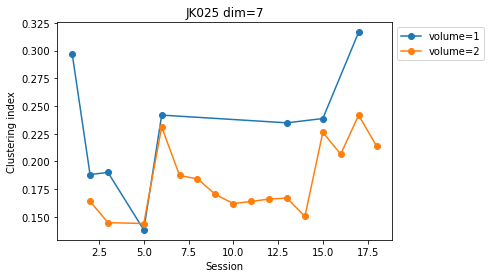

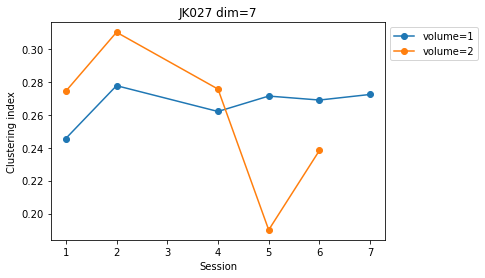

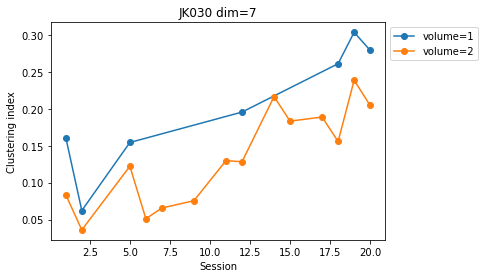

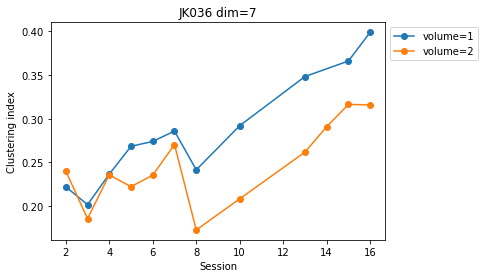

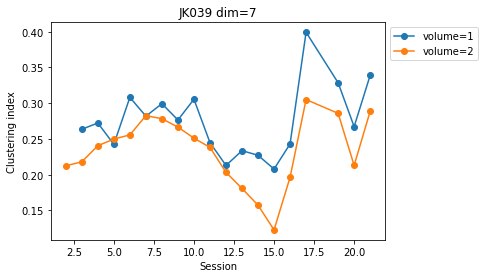

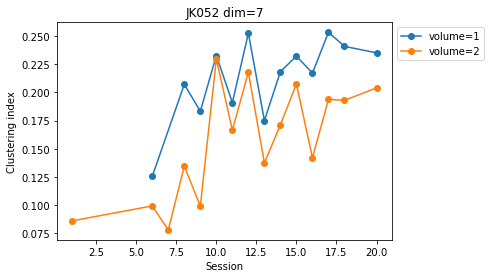

In [47]:
varexp_threshold = 0.05
post_touch_frames = 1
num_dims = 7

for mouse in mice:
    fig, ax = plt.subplots()
    for volume in [1,2]:
        temp_df = training_volume_df.query('mouse==@mouse and volume==@volume')
        sessions = [int(s) for s in temp_df.session.values]
        ci_sessions = []
        ci_session_nums = []
        for session in sessions:
            touch_response_fn = f'JK{mouse:03}_volume{volume}_S{session:02}_ve_{varexp_threshold}_ptf_{post_touch_frames}.npy'
            touch_response_results = np.load(load_dir / touch_response_fn, allow_pickle=True).item()
            response_xr = touch_response_results['per_touch_response_xr_fit']
            response_df = touch_response_results['per_touch_response_df']
            try:
                clustering_index = ci.calculate_clustering_index(response_xr, response_df, num_dims=num_dims)
                ci_session_nums.append(session)
                ci_sessions.append(clustering_index)
            except:
                pass
        ci_sessions = np.array(ci_sessions)

        ax.plot(ci_session_nums, ci_sessions, 'o-', label=f'volume={volume}')
    ax.legend(loc='upper left', bbox_to_anchor=(1,1))
    ax.set_xlabel('Session')
    ax.set_ylabel('Clustering index')
    ax.set_title(f'JK{mouse:03} dim={num_dims}')

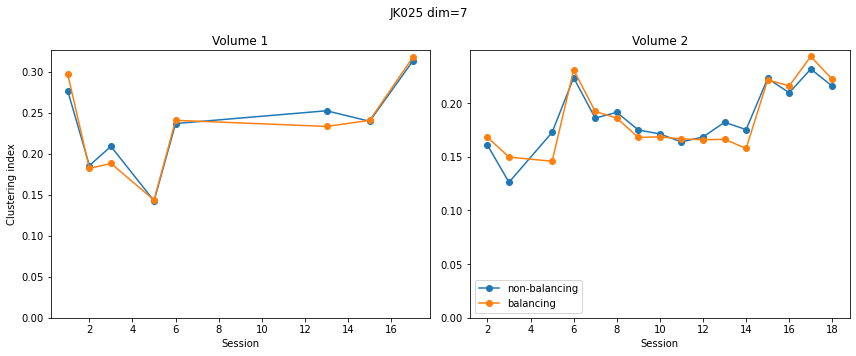

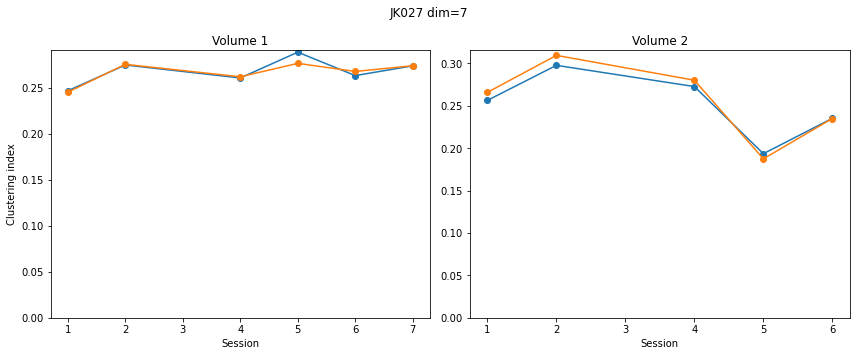

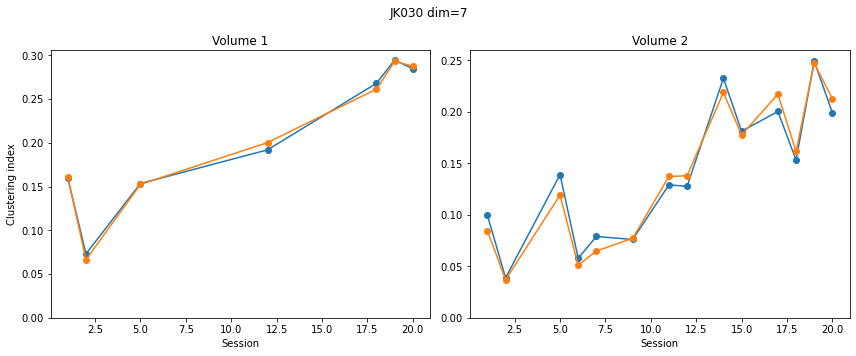

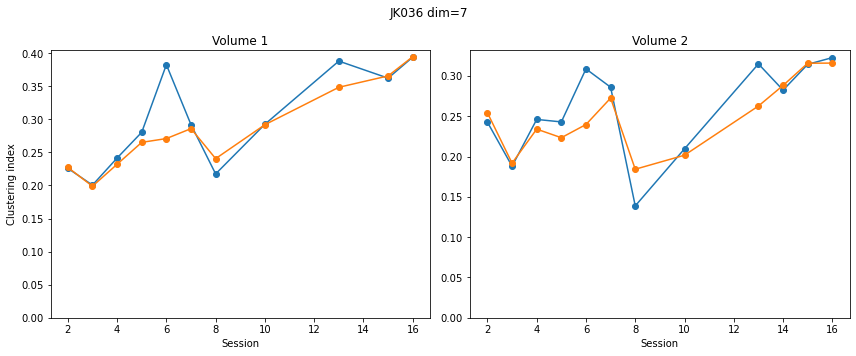

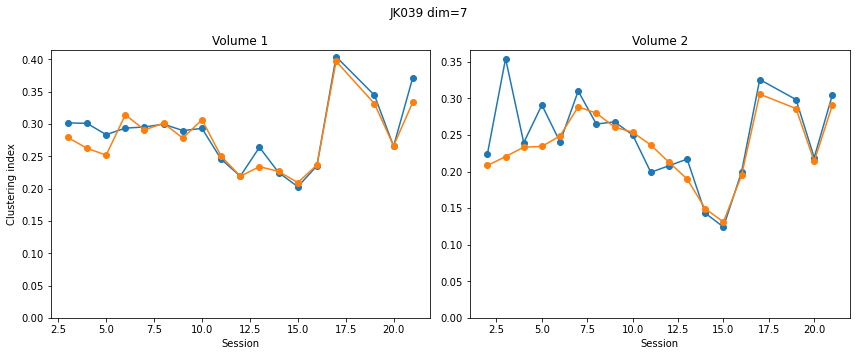

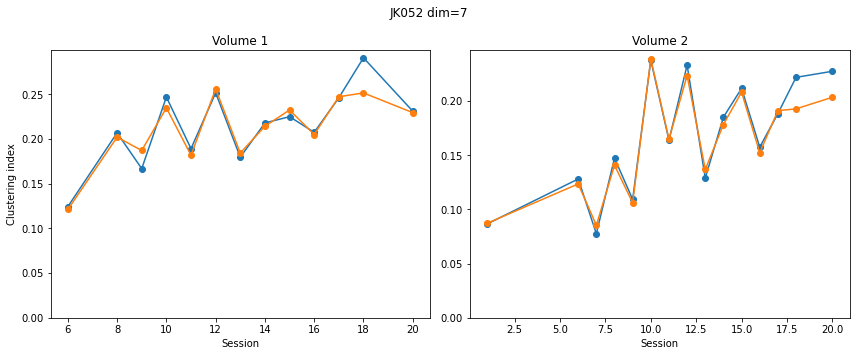

In [51]:
# Compare between matching vs not
varexp_threshold = 0.05
post_touch_frames = 1
num_dims = 7

for mi, mouse in enumerate(mice):
    fig, ax = plt.subplots(1,2, figsize=(12,5))
    for vi, volume in enumerate([1,2]):
        temp_df = training_volume_df.query('mouse==@mouse and volume==@volume')
        sessions = [int(s) for s in temp_df.session.values]
        ci_sessions = []
        ci_session_nums = []
        for session in sessions:
            touch_response_fn = f'JK{mouse:03}_volume{volume}_S{session:02}_ve_{varexp_threshold}_ptf_{post_touch_frames}.npy'
            touch_response_results = np.load(load_dir / touch_response_fn, allow_pickle=True).item()
            response_xr = touch_response_results['per_touch_response_xr_fit']
            response_df = touch_response_results['per_touch_response_df']
            try:
                clustering_index = ci.calculate_clustering_index(response_xr, response_df,
                                                                 num_dims=num_dims,
                                                                 balance_trials=False)
                ci_session_nums.append(session)
                ci_sessions.append(clustering_index)
            except:
                pass
        ci_sessions = np.array(ci_sessions)
        ax[vi].plot(ci_session_nums, ci_sessions, 'o-', label=f'non-balancing')
        ci_sessions = []
        ci_session_nums = []
        for session in sessions:
            touch_response_fn = f'JK{mouse:03}_volume{volume}_S{session:02}_ve_{varexp_threshold}_ptf_{post_touch_frames}.npy'
            touch_response_results = np.load(load_dir / touch_response_fn, allow_pickle=True).item()
            response_xr = touch_response_results['per_touch_response_xr_fit']
            response_df = touch_response_results['per_touch_response_df']
            try:
                clustering_index = ci.calculate_clustering_index(response_xr, response_df,
                                                                 num_dims=num_dims)
                ci_session_nums.append(session)
                ci_sessions.append(clustering_index)
            except:
                pass
        ci_sessions = np.array(ci_sessions)
        ax[vi].plot(ci_session_nums, ci_sessions, 'o-', label=f'balancing')
        ax[vi].set_xlabel('Session')
        ax[vi].set_title(f'Volume {volume}')
        ylims = ax[vi].get_ylim()
        ax[vi].set_ylim([0, ylims[1]])
    ax[0].set_ylabel('Clustering index')
    fig.suptitle(f'JK{mouse:03} dim={num_dims}')
    if mi == 0:
        ax[1].legend()
    fig.tight_layout()

# Check touch quality
- Distribution of touch counts, sliding distance, vertical and horizontal bending, etc.

In [53]:
mouse = 25
volume = 1
plane = 1 if volume==1 else 5
temp_df = training_volume_df.query('mouse==@mouse and volume==@volume')
sessions = [int(s) for s in temp_df.session.values]
session = sessions[0]
plane_dir = base_dir / f'{mouse:03}/plane_{plane}'
fwb_fn = plane_dir / f'JK{mouse:03}_S{session:02}_plane{plane}_frame_whisker_behavior.pkl'
fwb = pd.read_pickle(fwb_fn)

In [54]:
fwb.head()

,trialNum,frame_start_time,frame_end_time,trial_duration,frame_index,kappaH_onset,kappaV_onset,phi_onset,theta_onset,arc_length_onset,...,first_reward_lick_right,correct,wrong,miss,trial_type,task_target,distractor,mouse_name,session_name,session_type
0,2,0.225488,0.257918,8.934645,0,NaN,NaN,NaN,NaN,NaN,...,False,True,False,False,ln,Angle,Off,JK025,S01,2port-Discrim
1,2,0.355207,0.387637,8.934645,1,NaN,NaN,NaN,NaN,NaN,...,False,True,False,False,ln,Angle,Off,JK025,S01,2port-Discrim
2,2,0.484926,0.517356,8.934645,2,NaN,NaN,NaN,NaN,NaN,...,False,True,False,False,ln,Angle,Off,JK025,S01,2port-Discrim
3,2,0.614645,0.647075,8.934645,3,NaN,NaN,NaN,NaN,NaN,...,False,True,False,False,ln,Angle,Off,JK025,S01,2port-Discrim
4,2,0.744364,0.776793,8.934645,4,NaN,NaN,NaN,NaN,NaN,...,False,True,False,False,ln,Angle,Off,JK025,S01,2port-Discrim


In [55]:
fwb.columns

Index(['trialNum', 'frame_start_time', 'frame_end_time', 'trial_duration',
       'frame_index', 'kappaH_onset', 'kappaV_onset', 'phi_onset',
       'theta_onset', 'arc_length_onset', 'touch_count', 'delta_kappaH',
       'delta_kappaV', 'delta_phi', 'delta_theta', 'slide_distance',
       'touch_duration', 'pole_up_frame', 'pole_moving_frame', 'theta',
       'midpoint', 'amplitude', 'num_whisks', 'pole_angle', 'pole_ap_distance',
       'pole_radial_distance', 'num_lick_left', 'num_lick_right',
       'answer_lick_frame', 'answer_lick_left', 'answer_lick_right',
       'pre_answer_pole_up_frame', 'answer_period_frame',
       'post_answer_pole_up_frame', 'first_reward_lick_frame',
       'first_reward_lick_left', 'first_reward_lick_right', 'correct', 'wrong',
       'miss', 'trial_type', 'task_target', 'distractor', 'mouse_name',
       'session_name', 'session_type'],
      dtype='object')

In [2]:
mouse = 25
volume = 1
plane = 1 if volume==1 else 5
temp_df = training_volume_df.query('mouse==@mouse and volume==@volume')
sessions = [int(s) for s in temp_df.session.values]
# sessions = [1,3,5,6]

angles = [45, 135]
slide_distance = []
touch_count = []
touch_duration = []
delta_kappaV = []
delta_kappaH = []
delta_phi = []
delta_theta = []
kappaH_onset = []
kappaV_onset = []
phi_onset = []
theta_onset = []
arc_length = []
for session in sessions:
    plane_dir = base_dir / f'{mouse:03}/plane_{plane}'
    fwb_fn = plane_dir / f'JK{mouse:03}_S{session:02}_plane{plane}_frame_whisker_behavior.pkl'
    fwb = pd.read_pickle(fwb_fn)

    sd = []
    tc = []
    td = []
    vb = []
    hb = []
    dph = []
    dth = []
    kho = []
    kvo = []
    pho = []
    tho = []
    alo = []

    for angle in angles:
        tc_df = fwb.query('pole_angle==@angle').groupby('trialNum').touch_count.sum()
        touch_tn = tc_df[tc_df!=0].index.values
        temp_df = fwb.query('trialNum in @touch_tn')
        sd.append(temp_df.groupby('trialNum').slide_distance.mean().values)
        tc.append(temp_df.groupby('trialNum').touch_count.sum().values)
        td.append(temp_df.groupby('trialNum').touch_duration.mean().values)
        vb.append(temp_df.groupby('trialNum').delta_kappaV.mean().values)
        hb.append(temp_df.groupby('trialNum').delta_kappaH.mean().values)
        dph.append(temp_df.groupby('trialNum').delta_phi.mean().values)
        dth.append(temp_df.groupby('trialNum').delta_theta.mean().values)
        kho.append(temp_df.groupby('trialNum').kappaH_onset.mean().values)
        kvo.append(temp_df.groupby('trialNum').kappaV_onset.mean().values)
        pho.append(temp_df.groupby('trialNum').phi_onset.mean().values)
        tho.append(temp_df.groupby('trialNum').theta_onset.mean().values)
        alo.append(temp_df.groupby('trialNum').arc_length_onset.mean().values)

    slide_distance.append(sd)
    touch_count.append(tc)
    delta_kappaV.append(vb)
    delta_kappaH.append(hb)
    delta_phi.append(dph)
    delta_theta.append(dth)
    touch_duration.append(td)
    kappaH_onset.append(kho)
    kappaV_onset.append(kvo)
    phi_onset.append(pho)
    theta_onset.append(tho)
    arc_length.append(alo)
    

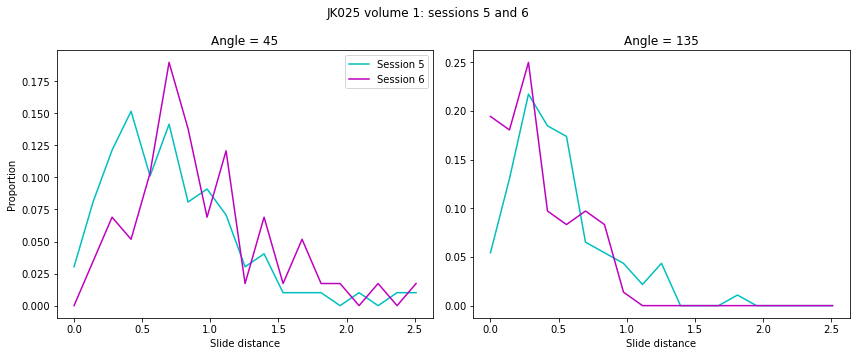

In [12]:
# compare between sessions
comp_inds = [3,4]
colors=['c','m']
total_sd = np.concatenate([np.concatenate(slide_distance[i]) for i in comp_inds])
sd_lim = [total_sd.min(), total_sd.max()]
bins = np.linspace(sd_lim[0], sd_lim[1], 20)
fig, ax = plt.subplots(1,2,figsize=(12,5))
for ai in range(2):
    for i in range(len(comp_inds)):
        hist, bin_edges = np.histogram(slide_distance[comp_inds[i]][ai], bins=bins)
        ax[ai].plot(bin_edges[:-1], hist/len(slide_distance[comp_inds[i]][ai]), color=colors[i], label=f'Session {sessions[comp_inds[i]]}')
    ax[ai].set_title(f'Angle = {angles[ai]}')
    ax[ai].set_xlabel('Slide distance')
ax[0].legend()
ax[0].set_ylabel('Proportion')
fig.suptitle(f'JK{mouse:03} volume {volume}: sessions {sessions[comp_inds[0]]} and {sessions[comp_inds[1]]}')
fig.tight_layout()


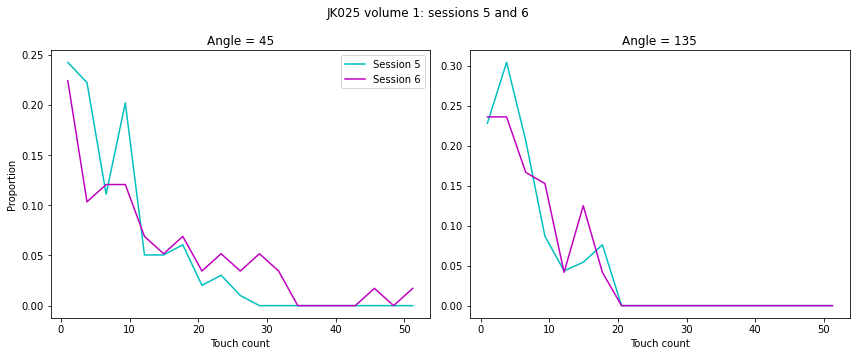

In [10]:
# compare between sessions
comp_inds = [3,4]
colors=['c','m']
total_sd = np.concatenate([np.concatenate(touch_count[i]) for i in comp_inds])
sd_lim = [total_sd.min(), total_sd.max()]
bins = np.linspace(sd_lim[0], sd_lim[1], 20)
fig, ax = plt.subplots(1,2,figsize=(12,5))
for ai in range(2):
    for i, ci in enumerate(comp_inds):
        hist, bin_edges = np.histogram(touch_count[ci][ai], bins=bins)
        ax[ai].plot(bin_edges[:-1], hist/len(touch_count[ci][ai]), color=colors[i], label=f'Session {sessions[ci]}')
    ax[ai].set_title(f'Angle = {angles[ai]}')
    ax[ai].set_xlabel('Touch count')
ax[0].legend()
ax[0].set_ylabel('Proportion')
fig.suptitle(f'JK{mouse:03} volume {volume}: sessions {sessions[comp_inds[0]]} and {sessions[comp_inds[1]]}')
fig.tight_layout()


In [3]:
feature_names = ['theta_onset', 'phi_onset', 'kappaH_onset', 'kappaV_onset', 'arc_length', 'touch_count',
                 'delta_theta', 'delta_phi', 'delta_kappaH', 'delta_kappaV', 'touch_duration', 'slide_distance']
feature_values = {'theta_onset': theta_onset, 'phi_onset': phi_onset, 'kappaH_onset': kappaH_onset, 'kappaV_onset': kappaV_onset,
                  'arc_length': arc_length, 'touch_count': touch_count, 'delta_theta': delta_theta, 'delta_phi': delta_phi,
                  'delta_kappaH': delta_kappaH, 'delta_kappaV': delta_kappaV, 'touch_duration': touch_duration, 'slide_distance': slide_distance}


Text(0.5, 0.98, 'JK025 volume 1')

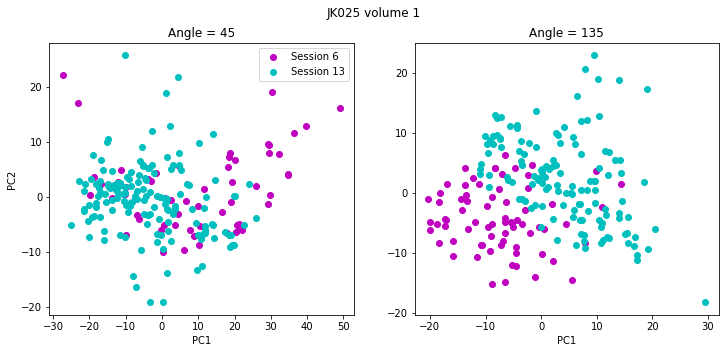

In [19]:
# Look at PCA between two sessions
# for each angle
sel_sessions = [6,13]
session_inds = [int(np.where(np.array(sessions)==s)[0]) for s in sel_sessions]
all_features = [[[] for ai in range(len(angles))] for i in range(len(sel_sessions))]

for si in range(len(session_inds)):
    for ai in range(len(angles)):
        for fn in feature_names:
            all_features[si][ai].append(feature_values[fn][session_inds[si]][ai])

for si in range(len(session_inds)):
    for ai in range(len(angles)):
        all_features[si][ai] = np.array(all_features[si][ai])

fig, ax = plt.subplots(1,2,figsize=(12,5))
for ai in range(2):    
    pca = PCA(svd_solver='arpack')
    pcs = pca.fit_transform(np.concatenate([all_features[0][ai], all_features[1][ai]], axis=1).T)
    num_first_session = all_features[0][ai].shape[1]
    ax[ai].scatter(pcs[:num_first_session,0], pcs[:num_first_session,1], color='m', label=f'Session {sel_sessions[0]}')
    ax[ai].scatter(pcs[num_first_session:,0], pcs[num_first_session:,1], color='c', label=f'Session {sel_sessions[1]}')
    
    ax[ai].set_xlabel('PC1')
    
    ax[ai].set_title(f'Angle = {angles[ai]}')
ax[0].legend()
ax[0].set_ylabel('PC2')
fig.suptitle(f'JK{mouse:03} volume {volume}')

